In [7]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import planck_colormap

cm = planck_colormap.colormap()
%matplotlib inline

In [32]:
# params
nside = 64
npix = hp.nside2npix(nside)
lmax = 3*nside//2
# importing Cls from theory
cl = np.load('input_files/cls_PlanckPR2_TT_lowp_lensing_lensed.npy')
# importing mask
mask = hp.read_map('input_files/commander_mask.fits',verbose=False)
#weights
weights_map = hp.read_map('input_files/full_weights_map_08_0064.fits')

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [11]:
# importing flm
import tempfile
import os
rootdir = os.getcwd() + "/output_files/"
flm_list = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        flm_list.append(np.load(os.path.join(subdir, file)))
flm_list = np.array(flm_list)

In [12]:
# importing wf map and getting crs
#wf_lm = np.load('ISW_WF_PPR2_hdu1.npy')
#cr_lm = wf + flm_list

/home/marcio/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


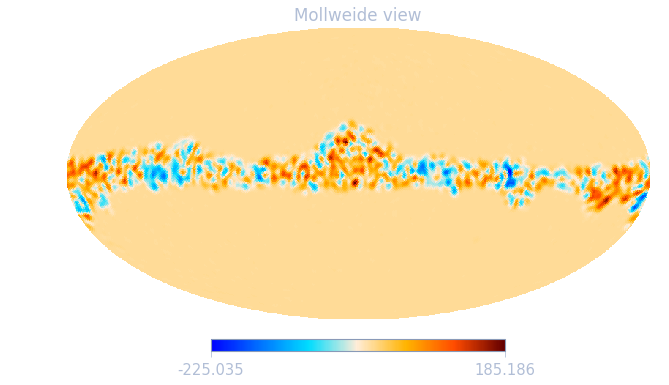

In [17]:
hp.mollview(hp.alm2map(flm_list[4],nside,lmax,verbose=False),cmap=cm)

In [63]:
# generating lcdm maps
n = len(cr_list)
lcdm_list = [0]*n
for i in range(n):
    lcdm_list[i] = hp.synalm(cl,lmax,verbose=False)
lcdm_list = np.array(lcdm_list)

### Studying Cls

In [64]:
# getting list of cls
def get_cls(alm_set,lmax):
    size = len(alm_set)
    cl_list = [0]*size
    for i in range(size):
        cl_list[i] = hp.alm2cl(alm_set[i],lmax=lmax)
    return np.array(cl_list)

In [67]:
cls_crs = get_cls(cr_list,lmax)
cls_lcdm = get_cls(lcdm_list, lmax)

In [73]:
# mean and stdev of cls
def cls_stats(cl_list):
    mean = np.mean(cl_list,axis=0)
    stdev = np.std(cl_list,axis=0)
    return mean, stdev

# dl from cl
def dl(cl):
    ell = np.arange(len(cl))
    return ell*(ell+1)*cl/(2*np.pi)

In [72]:
cls_crs_mean, cls_crs_stdev = cls_stats(cls_crs)
cls_lcdm_mean, cls_lcdm_stdev = cls_stats(cls_lcdm)

In [87]:
# plot mean and stdev
def plot_dls(ax, cls_mean, cls_stdev, color, label):
    ell = np.arange(len(cls_mean))
    ax.fill_between(ell, y1=dl(cls_mean + cls_stdev), y2=dl(cls_mean - cls_stdev),
                    color=color, alpha=0.3)
    ax.plot(ell, dl(cls_mean),color=color,label=label, lw =2)

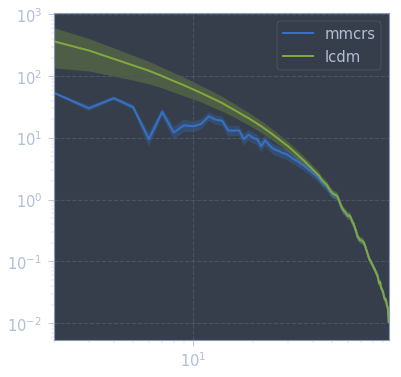

In [97]:
fig, ax1 = plt.subplots(1,1,figsize=(6,6),sharex=True)

plot_dls(ax1,cls_crs_mean,cls_crs_stdev,'C0', 'mmcrs')
plot_dls(ax1,cls_lcdm_mean,cls_lcdm_stdev,'C1', 'lcdm')

ax1.legend()
ax1.set_xlim(2,lmax)
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()

## Variance

In [21]:
### getting pixel space maps
cr_maps = [hp.alm2map(alm,nside,lmax,verbose=False) for alm in cr_lm]
cr_maps = np.array(cr_maps)

1440

In [33]:
ecl_mask = np.zeros(npix)
ecl_mask[:npix//2] = 1
ecl_mask_lm = hp.map2alm(ecl_mask*weights_map,lmax,iter=0)

In [50]:
### rotate map from ecl to galactic coordinates
rotmat = hp.rotator.get_coordconv_matrix(('E','G'))[0]
a1 = np.arctan2(rotmat[2,1],-rotmat[2,0])
a2 = np.arccos(rotmat[2,2])
a3 = np.arctan2(rotmat[1,2],rotmat[0,2]) 

alm_rot = np.copy(ecl_mask_lm)
hp.rotate_alm(alm_rot, a1, a2, a3)
ecl_mask_gal = hp.alm2map(alm_rot,nside,lmax,verbose=False)
ecl_mask_gal[ecl_mask_gal >=0.5] = 1
ecl_mask_gal[ecl_mask_gal <0.5] = 0

In [53]:
# booleans for each ecliptic hemisphere
ecl_north = ecl_mask_gal == 1
ecl_south = ecl_mask_gal == 0

In [ ]:
# function to get variances from map